# Tagging genes with ddlite: learning and labeling function iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We'll start to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [4]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import cPickle
import numpy as np
import matplotlib
# print(os.environ['SNORKELDB'])
# Use production DB
from set_env import set_env
set_env() 
sys.path.insert(1, '../snorkel')

# Must set SNORKELDB before importing SnorkelSession
from snorkel import SnorkelSession
from snorkel.parser import TextDocPreprocessor
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
session = SnorkelSession()

#np.random.seed(seed=1701)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

## Loading candidate extractions
First, we'll load in the candidates that we created in the last notebook. We can construct an docs object with the file.

In [5]:
GenePhenoPair = candidate_subclass('GenePhenoPair', ['gene', 'pheno'])

docs = session.query(GenePhenoPair).filter(GenePhenoPair.split == 0).all()  #should edit split to be 1. 

print "Documents:", session.query(Document).count()
print "Sentences:", session.query(Sentence).count()

##Once we get all the labels, for loop through all docs and split into train, dev, test. 

print 'Document set:\t{0} candidates'.format(len(docs))

/home/CS341_Arabidopsis/venv/local/lib/python2.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:120: SAWarning: This declarative base already contains a class with the same class name and module name as snorkel.models.candidate.GenePhenoPair, and will be replaced in the string-lookup table.
  item.__name__


InvalidRequestError: Table 'gene_pheno_pair' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.

## Make Labeling Functions

In [30]:
import re
import os
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_doc_candidate_spans,
    get_sent_candidate_spans,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
    
)

def LF_gene(c):
    return 1 if ('gene' in get_right_tokens(c, attrib='lemmas')) or ('gene' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_mutant(c):
    return 1 if ('mutant' in get_right_tokens(c, attrib='lemmas')) or ('mutant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_variant(c):
    return 1 if ('variant' in get_right_tokens(c, attrib='lemmas')) or ('variant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_express(c):
    return 1 if ('express' in get_right_tokens(c, attrib='lemmas')) or ('express' in get_left_tokens(c, attrib='lemmas')) else 0  
def LF_JJ(c):
    return 1 if 'JJ' in get_right_tokens(c, attrib='pos_tags') else 0
def LF_IN(c):
    return 1 if 'IN' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_dna(c):
    return -1 if contains_token(c, 'DNA', attrib='words') else 0
def LF_rna(c):
    return -1 if contains_token(c, 'RNA', attrib='words') else 0
def LF_snp(c):
    return -1 if contains_token(c, 'SNP', attrib='words') else 0
def LF_protein(c):
    return -1 if 'protein' in get_left_tokens(c, attrib='lemmas') else 0
def LF_LRB(c):
    return -1 if '-LRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_RRB(c):
    return -1 if '-RRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0    
def LF_NNP(c):
    return -1 if contains_token(c, 'NNP', attrib='pos_tags') else 0

action_link_words = set(['affect', 'lead', 'led', 'show', 'display', 'exhibit', 'cause', 'result in'])
mutant_words = set(['mutant', 'mutation', 'plant', 'line', 'phenotype', 'seedlings', 'variant'])
helper_vbs = set(['is', 'was', 'are', 'were', 'become', 'became'])
tester_words = set(['sequence', 'published', 'diagram', 'hypothesis', 'hypothesize', 'aim', 'goal', 'understand', 'examine', 'we', 'our', 'experiment', 'test', 'study', 'design', 'analyze', 'analysis', 'results', 'research'])

def lf1(c):
    return 1 if 'in' in get_between_tokens(c, attrib='words') else 0

def lf2(c):
    return 1 if len(action_link_words.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0

def lf2a(c):
    for aw in action_link_words:
        if contains_token(c[1], aw, attrib='lemmas'): return 1
    return 0

def lf3(c):
    return 1 if contains_token(c[1], 'JJR', attrib='pos_tags') else 0

def lf4(c):
    return 1 if contains_token(c[1], r'fold') or contains_token(c[1], r'\d+(\.\d+_)?%') or contains_token(c[1], 'percent') else 0

def lf5(c):
    return 1 if len(mutant_words.intersection(set(get_left_tokens(c[0], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c[0], attrib='lemmas')))) > 0 else 0

def lf6(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=3)))) > 0 else 0

def lf7(c):
    return -1 if 'not' in get_between_tokens(c) else 0

def lf8(c):
    return -1 if 'not' in get_left_tokens(c[0]) or 'not' in get_left_tokens(c[1]) else 0

def lf9(c):
    return -1 if 'level' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf10(c):
    return -1 if 'transcript' in get_left_tokens(c[0], attrib='lemmas', n_max=3) or 'transcript' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf11(c):
    return -1 if not contains_token(c[1], 'JJR', attrib='pos_tags') and not contains_token(c[1], 'JJ', attrib='pos_tags') and not contains_token(c[1], 'VBN', attrib='pos_tags') else 0

def inverted(c):
    return 1 if is_inverted(c) else 0

def lf12(c):
    return 1 if inverted(c) and lf1(c) else 0

def lf13(c):
    return 1 if inverted(c) and 'IN' in get_between_tokens(c, attrib='pos_tags', n_max=4) else 0

def lf14(c):
    return 1 if contains_token(c[1], 'phenotype', attrib='lemmas') else 0

def lf15(c):
    return -1 if 'protein' in get_left_tokens(c[0], attrib='lemmas') or 'protein' in get_right_tokens(c[0], attrib='lemmas') else 0

def lf16(c):
    return -1 if 'activity' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=1) else 0

def lf17(c):
    return -1 if len(tester_words.intersection(set(get_tagged_text(c).split()))) > 0 else 0

def LF_gene_dp(c):
    return 1 if 'gene' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
def LF_genotype_dp(c):
    return 1 if 'genotype' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
def LF_phenotype_dp(c):
    return 1 if 'phenotype' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_mutation(c):
    return 1 if ('mutation' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutant' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutations' in get_right_tokens(c[0], window=2, attrib='lemmas')) else 0

def LF_pheno(c):
    return 1 if contains_token(c, 'phenotype', attrib='words') else 0

def LF_dev_dp(c):
    return -1 if 'development' in get_right_tokens(c[1], window=2, attrib='lemmas')  else 0
def LF_protein_dp(c):
    return -1 if 'protein' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_network_dp(c):
    return -1 if 'network' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_JJ_dp(c):
    return -1 if 'JJ' in get_right_tokens(c[1], window=2, attrib='pos_tags') else 0

def lf_helpers(c):
    return 1 if any(word in get_left_tokens(c[1], window=2, attrib='words') for word in ['had', 'has', 'was', 'have']) else 0

adj_words = set(['increase', 'lower', 'reduce', 'higher', 'less', 'more', 'elevate', 'decrease', 'insensitive', 'absence'])
def lf_adjwords(c):
    for aw in adj_words:
        if contains_token(c[1], aw, attrib='lemmas'): return 1
    return 0
    
stats_words = set(['statistically', 'quantitative', 'real-time', 'generated', 'exposed', 'stratified'])
def lf_statswords(c):
    for aw in adj_words:
        if contains_token(c[1], aw, attrib='lemmas'): return -1
    return 0

def lfj_1(c):
     return 1 if any([word in get_left_tokens(c[1], window=2, attrib='words') for word in ['is', 'are']]) else 0
        
def lfj_2(c):
    return 1 if any([word in get_left_tokens(c[1], window=2, attrib='words') for word in ['showed', 'were', 'results']]) else 0
    
def lfj_3(c):
    return 1 if any([contains_token(c[1], word, attrib='lemmas') for word in ['affected',]]) else 0

def lfj_4(c):
    return -1 if any([contains_token(c, word, attrib='words') for word in ['brassica', 'rapeseed']]) else 0

def lfj_5(c):
    return -1 if any([contains_token(span, 'brassica', attrib='words') for span in get_doc_candidate_spans(c)]) else 0

def lfj_6(c):
    return -1 if 'table' in get_right_tokens(c[1], window=3, attrib='lemmas') else 0

def lfj_7(c):
    return 1 if 'mutation' in get_right_tokens(c[1], window=7, attrib='lemmas') else 0

def lfj_8(c):
    return 1 if 'mutants' in get_right_tokens(c[0], window=1, attrib='words') else 0

def lfj_9(c):
    return -1 if len(get_sent_candidate_spans(c)) > 6 else 0

def lfj_10(c):
    return -1 if 'we' in get_left_tokens(c[0], window=10, attrib='words') else 0
    
# tablex
# www.
# rna

## before phenotype
# mutant
# results
# had
# has
# was
# have
# showed
# were
# is
# are


# dependency parents test. 
# def LF_gene_dp(c):
#     return 1 if 'gene' in [c.get_parent()[i] for i in (c[0]).get_attrib_tokens('dep_parents')] else 0

    


In [18]:
def lf18(c):
    return 1 if 'mutant' in get_tagged_text(c).split() or 'mutation' in get_text_splits(c) else 0

def lf19(c):
    lemmas = c[1].get_attrib_tokens('lemmas')
    poses = c[1].get_attrib_tokens('pos_tags')
    for i, w in enumerate(poses):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            return 1
    return 0

def lf20(c):
    lemmas = c[1].get_attrib_tokens('lemmas')
    poses = c[1].get_attrib_tokens('pos_tags')
    result = 0
    for i, w in enumerate(lemmas):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = 0
        elif re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = -1
    return result

def lf21(c):
    return rule_regex_search_btw_BA(c, '.* in .*', 1)

def lf22(c):
    return -1 if 'expression' in get_right_tokens(c[0], attrib='lemmas', window=2) or 'expression' in get_left_tokens(c[0], attrib='lemmas', window=2) else 0
    
def lf23(c):
    return -1 if not inverted(c) and len(helper_vbs.intersection(set(get_left_tokens(c[1], window = 1, attrib='lemmas')))) > 0 and ('VBN' == c[1].get_attrib_tokens('pos_tags')[0] or ('VBN' == c[1].get_attrib_tokens('pos_tags')[1] and 'RB' == c[1].get_attrib_tokens('pos_tags')[0])) else 0

def lf24(c):
    return -1 if not contains_token(c[1], 'VB', attrib='pos_tags') and not contains_token(c[1], 'VBZ', attrib='pos_tags') and not contains_token(c[1], 'VBD', attrib='pos_tags') else 0

def lf25(c):
    return -1 if 'IN' == c[1].get_attrib_tokens('pos_tags')[0] or 'TO' == c[1].get_attrib_tokens('pos_tags')[0] else 0

def lf26(c):
    return -1 if 'JJR' == c[1].get_attrib_tokens('pos_tags')[0] and len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[1].get_attrib_tokens('pos_tags')[1]))) == 0 else 0

def lf27(c):
    hasNoNoun = len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[1].get_attrib_tokens('pos_tags')[1]))) == 0
    return -1 if len(c[1]) < 3 and hasNoNoun else 0
                  
def lf28(c):
    lastWordAdj = True if c[1].get_attrib_tokens('pos_tags')[-1] in set(['JJ', 'JJR']) else False
    nextLastVerb = True if c[1].get_attrib_tokens('lemmas')[-2] in helper_vbs else False
    return -1 if not nextLastVerb and lastWordAdj else 0              
    
def lf29(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30(c):                #if ends in prep, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

In [ ]:
#Skipping over dependency parent LFs. 
''' Dependency Parents 
def LF_gene_dp(m):
    return 1 if 'gene' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_genotype_dp(m):
    return 1 if 'genotype' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_mutation(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0


def LF_dev_dp(m):
    return -1 if 'development' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_protein_dp(m):
    return -1 if 'protein' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_network_dp(m):
    return -1 if 'network' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ_dp(m):
    return -1 if 'JJ' in [m.poses[m.dep_parents[i] - 1] for i in m.idxs] else 0
'''

In [55]:
from snorkel.models.context import TemporaryContext
import re


print docs[15]
sent = docs[15].get_parent()
print sent
text = sent._asdict()['text']
splt = text.split()
print splt
print splt[4:5]
print "\n"
print "REGEX VERSION: "

resplit = re.split(' ',text)
print resplit
print resplit[4:5]
print "\n"

print docs[15].get_contexts()
print (docs[15][0]).get_attrib_tokens('words')
# print (docs[15][0]).get_attrib_tokens('dep_parents')

#print LF_DP(docs[0])
print get_text_splits(docs[15])

GenePhenoPair2(Span("srfr1-4", sentence=1167385, chars=[164,170], words=[26,26]), Span("Because the transgenic copy of", sentence=1167385, chars=[0,29], words=[0,4]))
Sentence(Document PMC2973837,29,Because the transgenic copy of SRFR1 prevented us from determining whether these T3 lines were homozygous or heterozygous for the srfr1-4 allele, we tested whether srfr1-4 segregated in the next generation by genotyping 15 progeny for each line. )
[u'Because', u'the', u'transgenic', u'copy', u'of', u'SRFR1', u'prevented', u'us', u'from', u'determining', u'whether', u'these', u'T3', u'lines', u'were', u'homozygous', u'or', u'heterozygous', u'for', u'the', u'srfr1-4', u'allele,', u'we', u'tested', u'whether', u'srfr1-4', u'segregated', u'in', u'the', u'next', u'generation', u'by', u'genotyping', u'15', u'progeny', u'for', u'each', u'line.']
[u'of']


REGEX VERSION: 
[u'Because', u'the', u'transgenic', u'copy', u'of', u'SRFR1', u'prevented', u'us', u'from', u'determining', u'whether', u'these'

# Running LFs on the Training Set

In [31]:
LFs = [
    LF_gene,
    LF_mutant,
    LF_variant,
    LF_express,
    LF_JJ,
    LF_IN,
    LF_dna,
    LF_rna,
    LF_snp,
    LF_protein,
    LF_LRB,
    LF_RRB,
    LF_NNP,
    lf1,
    lf2,
    lf3,
    lf4,
    lf5,
    lf6,
    lf7,
    lf8,
    lf9,
    lf10,
    lf11,
    lf2a,
    lf12,
    lf13,
    lf14,
    lf15,
    lf16,
    lf17,
    lf18,
    lf19,
    lf20,
    lf21,
    lf22,
    lf23,
    lf24,
    lf25,
    lf26,
    lf27,
    lf28,
    lf29,
    lf30,
    LF_gene_dp,
    LF_genotype_dp,
    LF_phenotype_dp,
    LF_mutation,
    LF_pheno,
    LF_dev_dp,
    LF_protein_dp,
    LF_network_dp,
    LF_JJ_dp,
    lf_helpers,
    lf_adjwords,
    lf_statswords,
    lfj_1,
    lfj_2,
    lfj_3,
    lfj_4,
    lfj_5,
    lfj_6,
    lfj_7,
    lfj_8,
#     lfj_9,
    lfj_10,
]

In [32]:
from snorkel.annotations import LabelAnnotator
import multiprocessing
labeler = LabelAnnotator(f=LFs)

In [33]:
%time L_train = labeler.apply(split=0, parallelism=multiprocessing.cpu_count())
L_train

Clearing existing...
Running UDF...


Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe


CPU times: user 5.8 s, sys: 444 ms, total: 6.25 s
Wall time: 3min 12s


<1073x66 sparse matrix of type '<type 'numpy.float64'>'
	with 5974 stored elements in Compressed Sparse Row format>

In [34]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_gene,0,0.018639,0.018639,0.017707
LF_mutant,1,0.016775,0.016775,0.016775
LF_variant,2,0.005592,0.005592,0.005592
LF_express,3,0.018639,0.018639,0.018639
LF_JJ,4,0.000000,0.000000,0.000000
LF_IN,5,0.000000,0.000000,0.000000
LF_dna,6,0.000000,0.000000,0.000000
LF_rna,7,0.000000,0.000000,0.000000
LF_snp,8,0.000000,0.000000,0.000000
LF_protein,9,0.007456,0.007456,0.007456


* <b>Coverage</b> is the fraction of candidates that the labeling function emits a non-zero label for.
* <b>Overlap</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* <b>Conflict</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

# Generative Model

In [35]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

42

In [9]:
deps # (lf, lf, relationship_type)

{(0, 4, 0),
 (0, 5, 0),
 (0, 6, 0),
 (0, 7, 0),
 (0, 8, 0),
 (0, 10, 0),
 (0, 11, 0),
 (0, 16, 0),
 (0, 18, 0),
 (0, 22, 0),
 (0, 26, 0),
 (0, 30, 0),
 (0, 31, 0),
 (0, 32, 0),
 (0, 33, 0),
 (0, 38, 0),
 (0, 39, 0),
 (1, 4, 0),
 (1, 5, 0),
 (1, 6, 0),
 (1, 7, 0),
 (1, 8, 0),
 (1, 10, 0),
 (1, 11, 0),
 (1, 16, 0),
 (1, 17, 0),
 (1, 18, 0),
 (1, 26, 0),
 (1, 30, 0),
 (1, 32, 0),
 (1, 33, 0),
 (1, 34, 0),
 (1, 36, 0),
 (1, 37, 0),
 (1, 38, 0),
 (1, 39, 0),
 (2, 3, 0),
 (2, 4, 0),
 (2, 5, 0),
 (2, 6, 0),
 (2, 7, 0),
 (2, 8, 0),
 (2, 10, 0),
 (2, 11, 0),
 (2, 16, 0),
 (2, 18, 0),
 (2, 26, 0),
 (2, 30, 0),
 (2, 31, 0),
 (2, 32, 0),
 (2, 33, 0),
 (2, 34, 0),
 (2, 36, 0),
 (2, 37, 0),
 (2, 38, 0),
 (2, 39, 0),
 (3, 4, 0),
 (3, 5, 0),
 (3, 6, 0),
 (3, 7, 0),
 (3, 8, 0),
 (3, 10, 0),
 (3, 11, 0),
 (3, 16, 0),
 (3, 18, 0),
 (3, 26, 0),
 (3, 30, 0),
 (3, 32, 0),
 (3, 33, 0),
 (3, 36, 0),
 (3, 38, 0),
 (3, 39, 0),
 (4, 5, 0),
 (4, 6, 0),
 (4, 7, 0),
 (4, 8, 0),
 (4, 9, 0),
 (4, 10, 0),
 (4, 11, 0),

In [36]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, epochs=2, decay=0.95, step_size=0.1/L_train.shape[0],
    init_acc=2.0, reg_param=0.0,
    verbose=True
)

FACTOR 0: STARTED BURN-IN...
FACTOR 0: DONE WITH BURN-IN
FACTOR 0: STARTED LEARNING
FACTOR 0: EPOCH #0
Current stepsize = 9.31966449208e-05
Learning epoch took 0.000 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  2.0

    weightId: 1
        isFixed: False
        weight:  2.0

    weightId: 2
        isFixed: False
        weight:  2.0

    weightId: 3
        isFixed: False
        weight:  2.0

    weightId: 4
        isFixed: False
        weight:  2.0

    weightId: 5
        isFixed: False
        weight:  2.0

    weightId: 6
        isFixed: False
        weight:  2.0

    weightId: 7
        isFixed: False
        weight:  2.0

    weightId: 8
        isFixed: False
        weight:  2.0

    weightId: 9
        isFixed: False
        weight:  2.0

    weightId: 10
        isFixed: False
        weight:  2.0

    weightId: 11
        isFixed: False
        weight:  2.0

    weightId: 12
        isFixed: False
        weight:  2.0

    weightId: 13
       

FACTOR 0: EPOCH #1
Current stepsize = 8.85368126747e-05
Learning epoch took 0.258 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  1.80326188257

    weightId: 1
        isFixed: False
        weight:  1.80438024231

    weightId: 2
        isFixed: False
        weight:  1.81817334576

    weightId: 3
        isFixed: False
        weight:  1.81621621622

    weightId: 4
        isFixed: False
        weight:  1.81975768872

    weightId: 5
        isFixed: False
        weight:  1.81835973905

    weightId: 6
        isFixed: False
        weight:  1.81994408201

    weightId: 7
        isFixed: False
        weight:  1.81901211556

    weightId: 8
        isFixed: False
        weight:  1.82068965517

    weightId: 9
        isFixed: False
        weight:  1.80838769804

    weightId: 10
        isFixed: False
        weight:  1.81519105312

    weightId: 11
        isFixed: False
        weight:  1.81798695247

    weightId: 12
        isFixed: False
        we

FACTOR 0: DONE WITH LEARNING


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [37]:
train_marginals = gen_model.marginals(L_train)

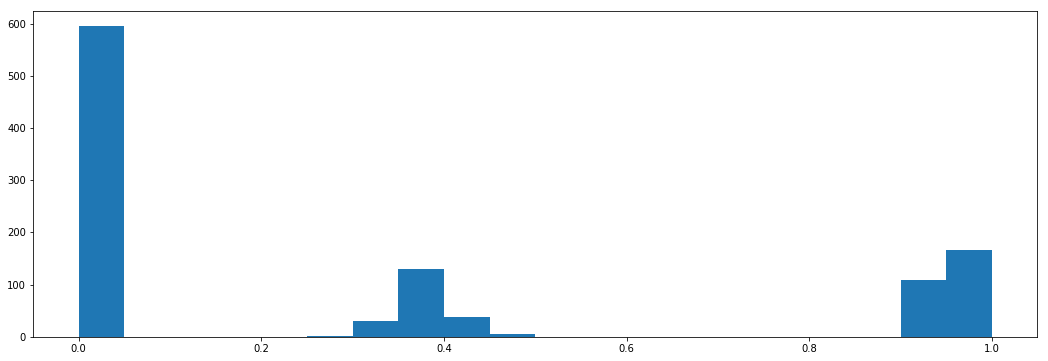

In [38]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [39]:
gen_model.weights.lf_accuracy()

array([ 0.83459839,  0.83482597,  0.83908808,  0.83812818,  0.83952863,
        0.83905347,  0.83901634,  0.83933267,  0.83946334,  0.83597357,
        0.83816927,  0.83887153,  0.83952738,  0.83455721,  0.83450059,
        0.83370231,  0.83872976,  0.83721956,  0.83897731,  0.83654401,
        0.83688016,  0.83553029,  0.83608536,  0.83445103,  0.83656503,
        0.83663574,  0.83917363,  0.837436  ,  0.83774977,  0.83585725,
        0.83998763,  0.83592053,  0.82296425,  0.8445395 ,  0.8368388 ,
        0.83630684,  0.83873732,  0.85049579,  0.84420148,  0.83411344,
        0.83857338,  0.84093735,  0.84023175,  0.83916356,  0.83570631,
        0.8391491 ,  0.8392277 ,  0.83670324,  0.83690687,  0.83579394,
        0.83585405,  0.83930125,  0.83908745,  0.834489  ,  0.83389346,
        0.83429648,  0.83819139,  0.83930628,  0.83956379,  0.83869635,
        0.83929874,  0.83873858,  0.83551172,  0.83509246,  0.84656532,
        0.83553093])

In [40]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 1073 training marginals


In [9]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

### Using the Model to Iterate on Labeling Functions
Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [ ]:
L_dev = labeler.apply_existing(split=1, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...


In [73]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [74]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.508
Neg. class accuracy: 0.696
Precision            0.217
Recall               0.508
F1                   0.304
----------------------------------------
TP: 96 | FP: 347 | TN: 796 | FN: 93



In [75]:
tp

{GenePhenoPair(Span("etr2-3", sentence=447956, chars=[13,18], words=[4,4]), Span("higher number of branched root hairs than the wild type", sentence=447956, chars=[26,80], words=[7,16])),
 GenePhenoPair(Span("atl9", sentence=450191, chars=[59,62], words=[10,10]), Span("more than two times the number of mature conidiophores", sentence=450191, chars=[107,160], words=[20,28])),
 GenePhenoPair(Span("atl9-3", sentence=450195, chars=[23,28], words=[5,5]), Span("in a more pronounced susceptibility phenotype than observed in wild", sentence=450195, chars=[53,119], words=[9,18])),
 GenePhenoPair(Span("atl9-1, atl9-2", sentence=450195, chars=[4,17], words=[1,3]), Span("more pronounced susceptibility phenotype than observed in wild type plants", sentence=450195, chars=[58,131], words=[11,20])),
 GenePhenoPair(Span("ALG10", sentence=388187, chars=[51,55], words=[12,12]), Span("reduced number of faster-migrating CPY-forms", sentence=388187, chars=[85,128], words=[18,22])),
 GenePhenoPair(Span("etr2

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!
In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).

## Doing Some Error Analysis

At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions. To do this, we can again just use the Viewer:

In [85]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session, height=400)
else:
    sv = None

<IPython.core.display.Javascript object>

In [86]:
sv

In [84]:
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_doc_candidate_spans,
    get_sent_candidate_spans,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
)
c = sv.get_selected() if sv else list(fp.union(fn))[0]
print(c)
print("\n")

c.labels
fp

GenePhenoPair(Span("deltaalg10", sentence=388171, chars=[223,232], words=[33,33]), Span("expressed the full-length Arabidopsis", sentence=388171, chars=[94,130], words=[14,17]))




{GenePhenoPair(Span("ALG10", sentence=388833, chars=[0,4], words=[0,0]), Span("deficiency suppresses the severe phenotypes of the", sentence=388833, chars=[6,55], words=[1,7])),
 GenePhenoPair(Span("alg10-1 cgl1", sentence=388637, chars=[7,18], words=[2,3]), Span("contains a null allele of GnTI, no signal", sentence=388637, chars=[103,143], words=[18,26])),
 GenePhenoPair(Span("atl9", sentence=450902, chars=[95,98], words=[14,14]), Span("mutant (0.77-fold)", sentence=450902, chars=[100,117], words=[15,18])),
 GenePhenoPair(Span("ms1", sentence=423726, chars=[80,82], words=[17,17]), Span("mutant (>1.6-fold change).", sentence=423726, chars=[122,147], words=[27,33])),
 GenePhenoPair(Span("EFR", sentence=450977, chars=[113,115], words=[24,24]), Span("mutant and in wild-type plants.", sentence=450977, chars=[198,228], words=[42,47])),
 GenePhenoPair(Span("nit1-3", sentence=446898, chars=[216,221], words=[40,40]), Span("enhances the tir-1-1 phenotype", sentence=446898, chars=[563,592], word

In [50]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

../snorkel/snorkel/annotations.py:80: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_gene,0,0.019520,0.019520,0.018769,2,24,0,0,0.076923,0.834598
LF_mutant,1,0.069069,0.069069,0.068318,10,73,0,0,0.120482,0.834826
LF_variant,2,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.839088
LF_express,3,0.010511,0.010511,0.010511,4,9,0,0,0.307692,0.838128
LF_JJ,4,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.839529
LF_IN,5,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.839053
LF_dna,6,0.000751,0.000751,0.000751,0,0,0,0,NaN,0.839016
LF_rna,7,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.839333
LF_snp,8,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.839463
LF_protein,9,0.007508,0.007508,0.007508,0,0,2,8,0.800000,0.835974


## Automatically Creating Features

In [76]:
from snorkel.annotations import FeatureAnnotator
import multiprocessing
featurizer = FeatureAnnotator()

In [77]:
%time F_train = featurizer.apply(split=0, parallelism=multiprocessing.cpu_count())
F_train

Clearing existing...
Running UDF...


KeyboardInterrupt: 


Next, we apply the feature set we just got from the training set to the dev and test sets by using apply_existing:

In [21]:
%%time
F_dev  = featurizer.apply_existing(split=1, parallelism=multiprocessing.cpu_count())
F_test = featurizer.apply_existing(split=2, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...
Clearing existing...
Running UDF...
CPU times: user 2min 45s, sys: 6.15 s, total: 2min 51s
Wall time: 9min 44s


In [22]:
F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_test  = featurizer.load_matrix(session, split=2)

## Training the Discriminative Model

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

In [ ]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()


Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.
Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [24]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


Next, we'll load in our dev set labels. We will pick the optimal result from the hyperparameter search by testing against these labels:

In [25]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

Finally, we run the hyperparameter search / train the end extraction model:

In [26]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=302  #epochs=50  batch size=100
[SparseLR] Epoch 0 (0.22s)	Avg. loss=0.746804	NNZ=17217
[SparseLR] Epoch 25 (1.14s)	Avg. loss=0.222985	NNZ=17217
[SparseLR] Epoch 49 (2.00s)	Avg. loss=0.215898	NNZ=17217
[SparseLR] Training done (2.00s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=302  #epochs=50  batch size=100
[SparseLR] Epoch 0 (0.21s)	Avg. loss=0.743375	NNZ=17217
[SparseLR] Epoch 25 (1.11s)	Avg. loss=0.664518	NNZ=17217
[SparseLR] Epoch 49 (1.96s)	Avg. loss=0.604258	NNZ=17217
[SparseLR] Training done (1.96s)
[3] Testing lr = 1.00e-03, l1_penalty = 1.00e-05, l2_penalty = 1.00e-05
[SparseLR] lr=0.001 l1=1e-05 l2=1e-0

,lr,l1_penalty,l2_penalty,Prec.,Rec.,F1
6,0.000001,0.001000,0.010000,0.195531,0.555556,0.289256
9,0.000001,0.000010,0.001000,0.172376,0.825397,0.285192
7,0.010000,0.000010,0.010000,0.166172,0.888889,0.280000
0,0.010000,0.001000,0.000100,0.162085,0.904762,0.274920
4,0.010000,0.000100,0.000010,0.162626,0.851852,0.273113
19,0.010000,0.000010,0.000100,0.161706,0.862434,0.272348
11,0.001000,0.000001,0.001000,0.160160,0.846561,0.269360
17,0.010000,0.000010,0.000001,0.155819,0.835979,0.262677
14,0.000100,0.010000,0.000010,0.154762,0.825397,0.260652
13,0.001000,0.000010,0.000100,0.156319,0.746032,0.258478



Note that to train a model without tuning any hyperparameters (at your own risk) just use the train method of the discriminative model. For instance, to train with 20 epochs and a learning rate of 0.001, you could run:
disc_model.train(F_train, train_marginals, n_epochs=20, lr=0.001)
We can analyze the learned model by examining the weights. For example, we can print out the features with the highest weights.

In [27]:
w, _ = disc_model.get_weights()
largest_idxs = reversed(np.argsort(np.abs(w))[-5:])
for i in largest_idxs:
    print 'Feature: {0: <70}Weight: {1:.6f}'.format(F_train.get_key(session, i).name, w[i])

Feature: TDL_INV_LEMMA:LEFT-OF-MENTION[methylesterification pectin in]         Weight: -0.386015
Feature: TDL_LEMMA:RIGHT-OF-MENTION[concentration lower figure]                Weight: -0.384107
Feature: TDL_LEMMA:SEQ-BETWEEN[wild-type , but]                                Weight: 0.368519
Feature: TDL_INV_LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[None indicate reduce]Weight: -0.362101
Feature: TDL_INV_LEMMA:RIGHT-OF-MENTION[these line transgenic]                 Weight: 0.361407



In this last section of the tutorial, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates we made in Part III.

In [28]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Now, we score using the discriminative model:

In [29]:
tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.36
Neg. class accuracy: 0.617
Precision            0.102
Recall               0.36
F1                   0.158
----------------------------------------
TP: 67 | FP: 593 | TN: 956 | FN: 119




Note that if this is the final test set that you will be reporting final numbers on, to avoid biasing results you should not inspect results. However you can run the model on your development set and, as we did in the previous part with the generative labeling function model, inspect examples to do error analysis.

##  LSTM

In the intro tutorial, we automatically featurized the candidates and trained a linear model over these features. Here, we'll train a more complicated model for relation extraction: an LSTM network. You can read more about LSTMs here or here. An LSTM is a type of recurrent neural network and automatically generates a numerical representation for the candidate based on the sentence text, so no need for featurizing explicitly as in the intro tutorial. LSTMs take longer to train, and Snorkel doesn't currently support hyperparameter searches for them. We'll train a single model here, but feel free to try out other parameter sets. Just make sure to use the development set - and not the test set - for model selection.

In [69]:
train = session.query(GenePhenoPair).filter(GenePhenoPair.split == 0).all()
dev = session.query(GenePhenoPair).filter(GenePhenoPair.split == 0).all()
test = session.query(GenePhenoPair).filter(GenePhenoPair.split == 2).all()

In [70]:
from snorkel.contrib.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 5
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train, train_marginals, dev_candidates=dev, dev_labels=dev_labels, **train_kwargs)

NameError: name 'dev_labels' is not defined

# Thomas's Code
## `DDLiteModel` objects and feature generation
We'll then create a `DDLiteModel` object for our extracted gene candidates. This lets us iterate with our model and labeling functions. Since `Entities` object defines a feature generation method, features are automatically created when we initialize a `DDLiteModel` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention. Alternatively, you can define a custom feature set as a NumPy array or a Scipy sparse matrix. Here, we pickle our feature matrix so we don't have to recompute it in the future.

In [3]:
feats = None

pkl_f = 'gene_tag_example/gene_tag_feats_v1.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time E.extract_features()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(E.feats, f)

DDL = DDLiteModel(E, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 30533 features for each of 1968 mentions


We need a blind, gold standard ground truth set to evaluate our predictions. We can add these by using the uids for the candidates we want, and align these with a value of 1 for positive or a value of -1 for negative. We'll load in a set now using `DDL.update_gt()` and set it as the holdout. We'll assign half of the holdout to a validation set for parameter tuning, and the other half to a test set.

In [4]:
with open('gene_tag_example/gt/uids.pkl', 'rb') as f:
    uids = cPickle.load(f)
with open('gene_tag_example/gt/gt.pkl', 'rb') as f:
    gt = cPickle.load(f)
    
DDL.update_gt(gt[:50], uids=uids[:50])
DDL.set_holdout(validation_frac=0.5)

../ddlite.py:602: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.dev1 = idxs[ : np.floor(dev_split * len(idxs))]
../ddlite.py:603: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.dev2 = idxs[np.floor(dev_split * len(idxs)) : ]
../ddlite.py:594: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.validation = h[ : np.floor(validation_frac * len(h))]
../ddlite.py:595: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.test = h[np.floor(validation_frac * len(h)) : ]


## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. If you aren't sure, you can abstain from labeling. In a real application, we would likely want to tag more than 20 candidates.

In [5]:
DDL.open_mindtagger(num_sample=100, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


Now, we'll retrieve the tags and add them to our `DDLiteModel`. We can also use a previously defined Mindtagger label set, similar to how we added our gold labels (this time, we'll use indexes instead of uids). These labels are used for evaluating our labeling functions against the *development set*.

In [6]:
DDL.add_mindtagger_tags()

In [7]:
DDL.update_gt(gt[50:], uids=uids[50:])

## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

In [8]:
def LF_gene(m):
    return 1 if ('gene' in m.post_window('lemmas')) or ('gene' in m.pre_window('lemmas')) else 0
def LF_gene_dp(m):
    return 1 if 'gene' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_genotype_dp(m):
    return 1 if 'genotype' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_mutant(m):
    return 1 if ('mutant' in m.post_window('lemmas')) or ('mutant' in m.pre_window('lemmas')) else 0
def LF_variant(m):
    return 1 if ('variant' in m.post_window('lemmas')) or ('variant' in m.pre_window('lemmas')) else 0
def LF_express(m):
    return 1 if ('express' in m.post_window('lemmas')) or ('express' in m.pre_window('lemmas')) else 0
def LF_mutation(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ(m):
    return 1 if 'JJ' in m.post_window('poses') else 0
def LF_IN(m):
    return 1 if 'IN' in m.pre_window('poses', 1) else 0

def LF_dna(m):
    return -1 if 'DNA' in m.mention('words') else 0
def LF_rna(m):
    return -1 if 'RNA' in m.mention('words') else 0
def LF_snp(m):
    return -1 if 'SNP' in m.mention('words') else 0
def LF_protein(m):
    return -1 if 'protein' in m.pre_window('lemmas') else 0
def LF_LRB(m):
    return -1 if '-LRB-' in m.post_window('poses', 1) else 0
def LF_RRB(m):
    return -1 if '-RRB-' in m.post_window('poses', 1) else 0
def LF_dev_dp(m):
    return -1 if 'development' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_protein_dp(m):
    return -1 if 'protein' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_network_dp(m):
    return -1 if 'network' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ_dp(m):
    return -1 if 'JJ' in [m.poses[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_NNP(m):
    return -1 if 'NNP' in m.mention('poses') else 0

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [9]:
LFs = [LF_JJ, LF_JJ_dp, LF_NNP, LF_RRB, LF_dev_dp, LF_dna, LF_express, LF_gene, LF_gene_dp,
       LF_genotype_dp, LF_mutant, LF_mutation, LF_network_dp, LF_protein, LF_protein_dp,
       LF_rna, LF_snp, LF_variant, LF_IN, LF_LRB]
DDL.apply_lfs(LFs, clear=False)

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

In [10]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	69.135%
Overlap:	30.083%
Conflict:	15.276%


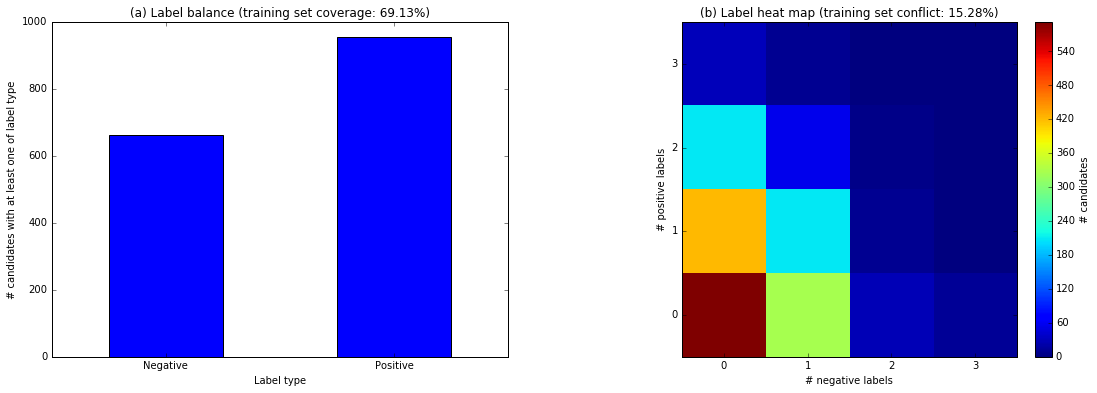

In [11]:
DDL.plot_lf_stats()

As we may expect, the few LFs do not cover the data very well. We can switch to an LF view of these measures and show tables for the LFs with the most conflict, lowest coverage, and lowest empirical accuracy as compared to the development set labels.

In [12]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_IN,7.98%
LF_NNP,6.52%
LF_JJ,5.27%


In [13]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_network_dp,0.10%
LF_dev_dp,0.21%
LF_express,0.78%


In [14]:
DDL.lowest_empirical_accuracy_lfs(n=10)

100% accuracy and 0 generalization score are "perfect"


../ddlite.py:564: UserWarning: Dev sets are too small for reliable estimates
  warnings.warn("Dev sets are too small for reliable estimates")


Labeling function,Positive accuracy,Gen. score
LF_mutant,0.00% (n=0),0.00 (n=0)
LF_express,0.00% (n=0),0.00 (n=0)
LF_gene_dp,0.00% (n=0),1.00 (n=3)
LF_IN,33.33% (n=6),0.27 (n=5)
LF_JJ,50.00% (n=4),0.00 (n=4)
LF_gene,100.00% (n=1),0.00 (n=3)
LF_variant,100.00% (n=2),0.00 (n=1)
LF_mutation,100.00% (n=1),0.00 (n=1)
LF_genotype_dp,100.00% (n=2),0.00 (n=1)
Labeling function,Negative accuracy,Gen. score


In [15]:
DDL.lf_summary_table()

Labelingfunction,Labeltype,Candidatecoverage,Candidateconflict,Positiveaccuracy,Positivegen. score,Negativeaccuracy,Negativegen. score
LF_rna,Negative,0.89%,0.31%,N/A,N/A,0.00% (n=0),0.00 (n=0)
LF_dev_dp,Negative,0.21%,0.21%,N/A,N/A,100.00% (n=1),1.00 (n=0)
LF_protein,Negative,0.94%,0.21%,N/A,N/A,100.00% (n=1),1.00 (n=0)
LF_NNP,Negative,10.74%,6.52%,N/A,N/A,100.00% (n=3),0.00 (n=2)
LF_LRB,Negative,4.59%,2.45%,N/A,N/A,0.00% (n=0),0.00 (n=0)
LF_JJ_dp,Negative,2.61%,1.46%,N/A,N/A,100.00% (n=1),1.00 (n=0)
LF_protein_dp,Negative,1.51%,0.63%,N/A,N/A,100.00% (n=1),1.00 (n=0)
LF_network_dp,Negative,0.10%,0.00%,N/A,N/A,0.00% (n=0),0.00 (n=0)
LF_RRB,Negative,13.50%,3.49%,N/A,N/A,75.00% (n=4),0.25 (n=1)
LF_snp,Negative,1.36%,0.36%,N/A,N/A,0.00% (n=0),1.00 (n=1)


Since our development set is small, we can't evaluate LF performance particularly well. If we observe LFs with very low accuracy, poor generalization, and a sufficiently large sample size, this could be an indication that the LF is buggy.

## Learning
To learn weights for the features and LFs, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more LFs. We'll tell ddlite to log the results and print out a summary table

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.094753
	Learning epoch = 250	Gradient mag. = 0.103007
Final gradient magnitude for rate=0.01, mu=1e-07: 0.110
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.027539
	Learning epoch = 250	Gradient mag. = 0.028324
	Learning epoch = 500	Gradient mag. = 0.027695
	Learning epoch = 750	Gradient mag. = 0.027098
	Learning epoch = 1000	Gradient mag. = 0.026531
	Learning epoch = 1250	Gradient mag. = 0.025994
	Learning epoch = 1500	Gradient mag. = 0.025483
	Learning epoch = 1750	Gradient mag. = 0.024998
	Learning epoch = 2000	Gradient mag. = 0.024538
	Learning epoch = 2250	Gradient mag. = 0.024099
	Learning epoch = 2500	Gradient mag. = 0.023682
	Learning epoch = 2750	Gradient mag. = 0.023284
Final gradient magnitude for rate=0.01, mu=1e-09: 0.023
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.027539
	Learning epoch = 250	Gradient mag. = 0.028325
	Learning epoch =

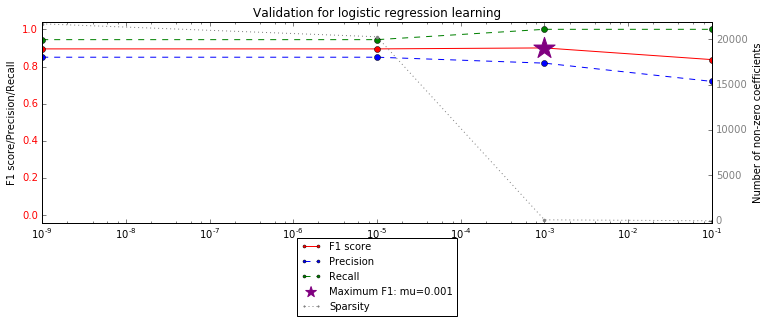

CPU times: user 18 s, sys: 213 ms, total: 18.2 s
Wall time: 18.2 s


<ddlite.ModelLog instance at 0x10fe581b8>

In [16]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions.

/usr/local/lib/python2.7/site-packages/numpy-1.11.0-py2.7-macosx-10.11-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


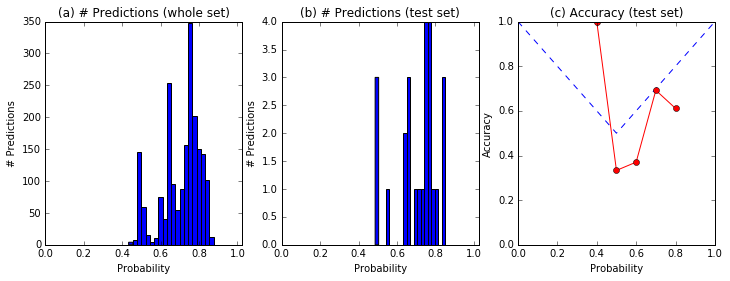

In [17]:
DDL.plot_calibration()

Since we used pipeline learning, we can also see the gain in accuracy we got from using features and not just LFs as a collection of rules.

In [18]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

LF accuracy: 0.680
Full model accuracy: 0.700


## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see some mentions that aren't currently covered by LFs.

In [19]:
DDL.show_log()

ID,# LFs,Test set size,Model,Precision,Recall,F1
0,20,25,Logistic regression,0.500,1.000,0.667


In [20]:
DDL.open_mindtagger(width='100%', height=1200, abstain=True)

Making sure MindTagger is installed. Hang on!


In order to use LSTM to learn weights, we just just call the following functions.

In [21]:
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'n_iter': 300, 'verbose': True, 'contain_mention': True, 'word_window_length': 0, 'ignore_case': False}
%time DDL.train_model(method='lstm', lf_opts=lf_opts, model_opts=model_opts)

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.094753
	Learning epoch = 250	Gradient mag. = 0.103007
Final gradient magnitude for rate=0.01, mu=1e-07: 0.110
Epoch #0, Training error: 0.508863
Epoch #1, Training error: 0.508863
Epoch #2, Training error: 0.508863
Epoch #3, Training error: 0.508863
Epoch #4, Training error: 0.508863
Epoch #5, Training error: 0.508863
Epoch #6, Training error: 0.508863
Epoch #7, Training error: 0.508863
Epoch #8, Training error: 0.508863
Epoch #9, Training error: 0.508863
Epoch #10, Training error: 0.508863
Epoch #11, Training error: 0.508863
Epoch #12, Training error: 0.508863
Epoch #13, Training error: 0.508863
Epoch #14, Training error: 0.508863
Epoch #15, Training error: 0.508863
Epoch #16, Training error: 0.508863
Epoch #17, Training error: 0.508863
Epoch #18, Training error: 0.508863
Epoch #19, Training error: 0.508863
Epoch #20, Training error: 0.508863
Epoch #21, Training error: 0.508863
Epoch #22, Training error: 0.50

In [22]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)

Full model accuracy: 0.720
